<a href="https://colab.research.google.com/github/siruku6/model_on_fer2013/blob/master/20220424_create_FER_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

- Information on kaggle  
[Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview)
- Document for dataset  
[FER2013 Dataset](https://docs.activeloop.ai/datasets/fer2013-dataset)

## labels

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



# 1. install modules

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

!pip install -q pytorch_lightning

# This is necessary for `torchvision.datasets.FER2013`
!pip install torchvision==0.12


env: CUBLAS_WORKSPACE_CONFIG=:4096:8
     |████████████████████████████████| 323 kB 15.1 MB/s 
     |████████████████████████████████| 6.2 MB 57.0 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 132 kB 49.8 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 8.7 MB 41.4 MB/s 
     |████████████████████████████████| 138 kB 47.1 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |███████████████

In [2]:
!pip list | grep torchvision

torchvision                   0.12.0


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Treating images
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18

import pytorch_lightning as pl


NumExpr defaulting to 2 threads.


# 2. load data & create dataset

torchvisionのFER2013管理モジュール

https://pytorch.org/vision/stable/generated/torchvision.datasets.FER2013.html

In [ ]:
dir(torchvision.datasets)

In [11]:
!unzip train.csv.zip
!mkdir fer2013
!mv train.csv fern2013/

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## normalizationのmean, stdの計算

In [43]:
transform = transforms.Compose([
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
pre_dataset = torchvision.datasets.FER2013('./', transform=transform)
pre_dataloader = torch.utils.data.DataLoader(pre_dataset, batch_size=40, shuffle=True, drop_last=True)


In [45]:
# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/8
mean = 0.
meansq = 0.
for data, label in tqdm(pre_dataloader):
    mean = data.mean()
    meansq = (data**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor(0.4942)
std: tensor(0.2614)



## Datasetの作成

In [46]:

transform = transforms.Compose([
    # TODO: training時のみこのtransformを適用したい
    #    要調査
    # https://medium.com/@reachraktim/emotion-recognition-on-the-fer-dataset-using-pytorch-835ce93d52a5
    # transforms.RandomAffine(degrees=10),
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # # PyTorch公式でもこのmean, stdが推奨されている -> 3 channels でないと使えないのでコメントアウト
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])

dataset = torchvision.datasets.FER2013('./', transform=transform)
dataset

Dataset FER2013
    Number of datapoints: 28709
    Root location: ./
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.4942], std=[0.2614])
           )

In [47]:
dataset[0][0]

tensor([[[-0.8404, -0.8404, -0.8404,  ..., -1.2755, -1.2755, -1.2755],
         [-0.8404, -0.8404, -0.8404,  ..., -1.2755, -1.2755, -1.2755],
         [-0.8404, -0.8404, -0.8404,  ..., -1.2755, -1.2755, -1.2755],
         ...,
         [-0.7354, -0.7354, -0.7354,  ..., -0.6604, -0.6754, -0.6754],
         [-0.7354, -0.7354, -0.7354,  ..., -0.6454, -0.6604, -0.6604],
         [-0.7354, -0.7354, -0.7354,  ..., -0.6454, -0.6604, -0.6604]]])

0


(-0.5, 223.5, 223.5, -0.5)

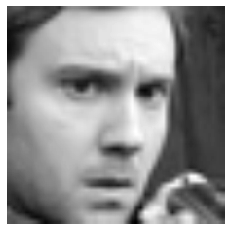

In [48]:
print(dataset[0][1])
plt.imshow(
    dataset[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

3


(-0.5, 223.5, 223.5, -0.5)

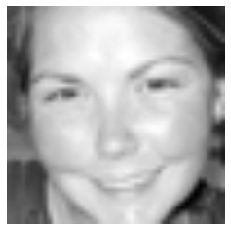

In [49]:
print(dataset[8][1])
plt.imshow(
    dataset[8][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

In [19]:
len(dataset)

28709

# 3. create dataloader

In [50]:
pl.seed_everything(0)

n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

batch_size = 40
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader


Global seed set to 0


6


(-0.5, 223.5, 223.5, -0.5)

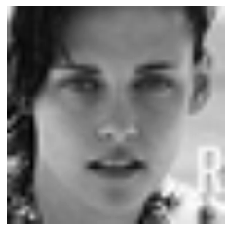

In [53]:
print(train[0][1])
plt.imshow(
    train[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

4


(-0.5, 223.5, 223.5, -0.5)

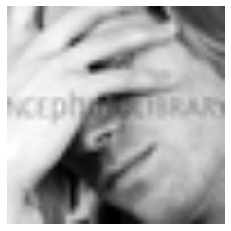

In [54]:
print(val[0][1])
plt.imshow(
    val[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')